In [1]:
import pandas as pd
import numpy as np
import json
from scipy.sparse import load_npz
import seaborn as sns
import anndata
import matplotlib.pyplot as plt

In [2]:
chroms = [
    'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
    'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
    'chr18', 'chr19', 'chrX'
]

corr_cutoff = 0.3
mask_dir = 'DMR_gene_1M_mask'

In [3]:
records = []
for chrom in chroms:
    print(chrom)
    corr_data = anndata.read_h5ad(f'MaskedResult/{chrom}.h5ad')
    
    # filter by cutoff
    corr_data.X = corr_data.X.multiply(corr_data.X > corr_cutoff)
    corr_data.X = corr_data.X.tocoo()
    
    int_to_dmr = {i: d for i, d in enumerate(corr_data.obs.index)}
    int_to_gene = {i: g for i, g in enumerate(corr_data.var.index)}
    
    corr_loops = pd.DataFrame({'DMR': corr_data.X.row, 
                               'Gene': corr_data.X.col, 
                               'Corr': corr_data.X.data})
    corr_loops['chrom'] = chrom
    corr_loops['DMR'] = corr_loops['DMR'].map(int_to_dmr)
    corr_loops['Gene'] = corr_loops['Gene'].map(int_to_gene)
    corr_loops.dropna(how='any', inplace=True)
    records.append(corr_loops)
total_loops = pd.concat(records)


chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX


In [4]:
with pd.HDFStore('/home/hanliu/project/mouse_rostral_brain/DMR/SubType/FilteredDMR.h5') as hdf:
    dmr_bed = hdf['Bed']
dmr_bed.index = 'Sub' + dmr_bed['#chr'] + '_' + dmr_bed.index.astype(str)
dmr_center = dmr_bed['start'] + (dmr_bed['end'] - dmr_bed['start']) / 2

In [76]:
gene_bed = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.bed',
                       index_col=3, header=None, sep='\t')
# there can be multiple tss for one gene, but most of them are not far and way less than 1mb..
# here I just use the first one
tss = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/genome_anno/TSS.all.bed',
                       index_col=1, header=None, sep='\t', usecols=[1, 3], squeeze=True).to_dict()
tss = pd.Series(tss)

In [79]:
dmr_center_ = dmr_center.loc[total_loops['DMR'].values].values
gene_tss_ = tss.loc[total_loops['Gene'].values].values
distance = dmr_center_ - gene_tss_

In [80]:
total_loops['DMR_to_gene_dist'] = distance
total_loops.to_msgpack(f'TotalGeneDMRCorrLoop.{corr_cutoff}.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


In [81]:
sample_loops = total_loops.sample(1000000)

(0.305, 1)

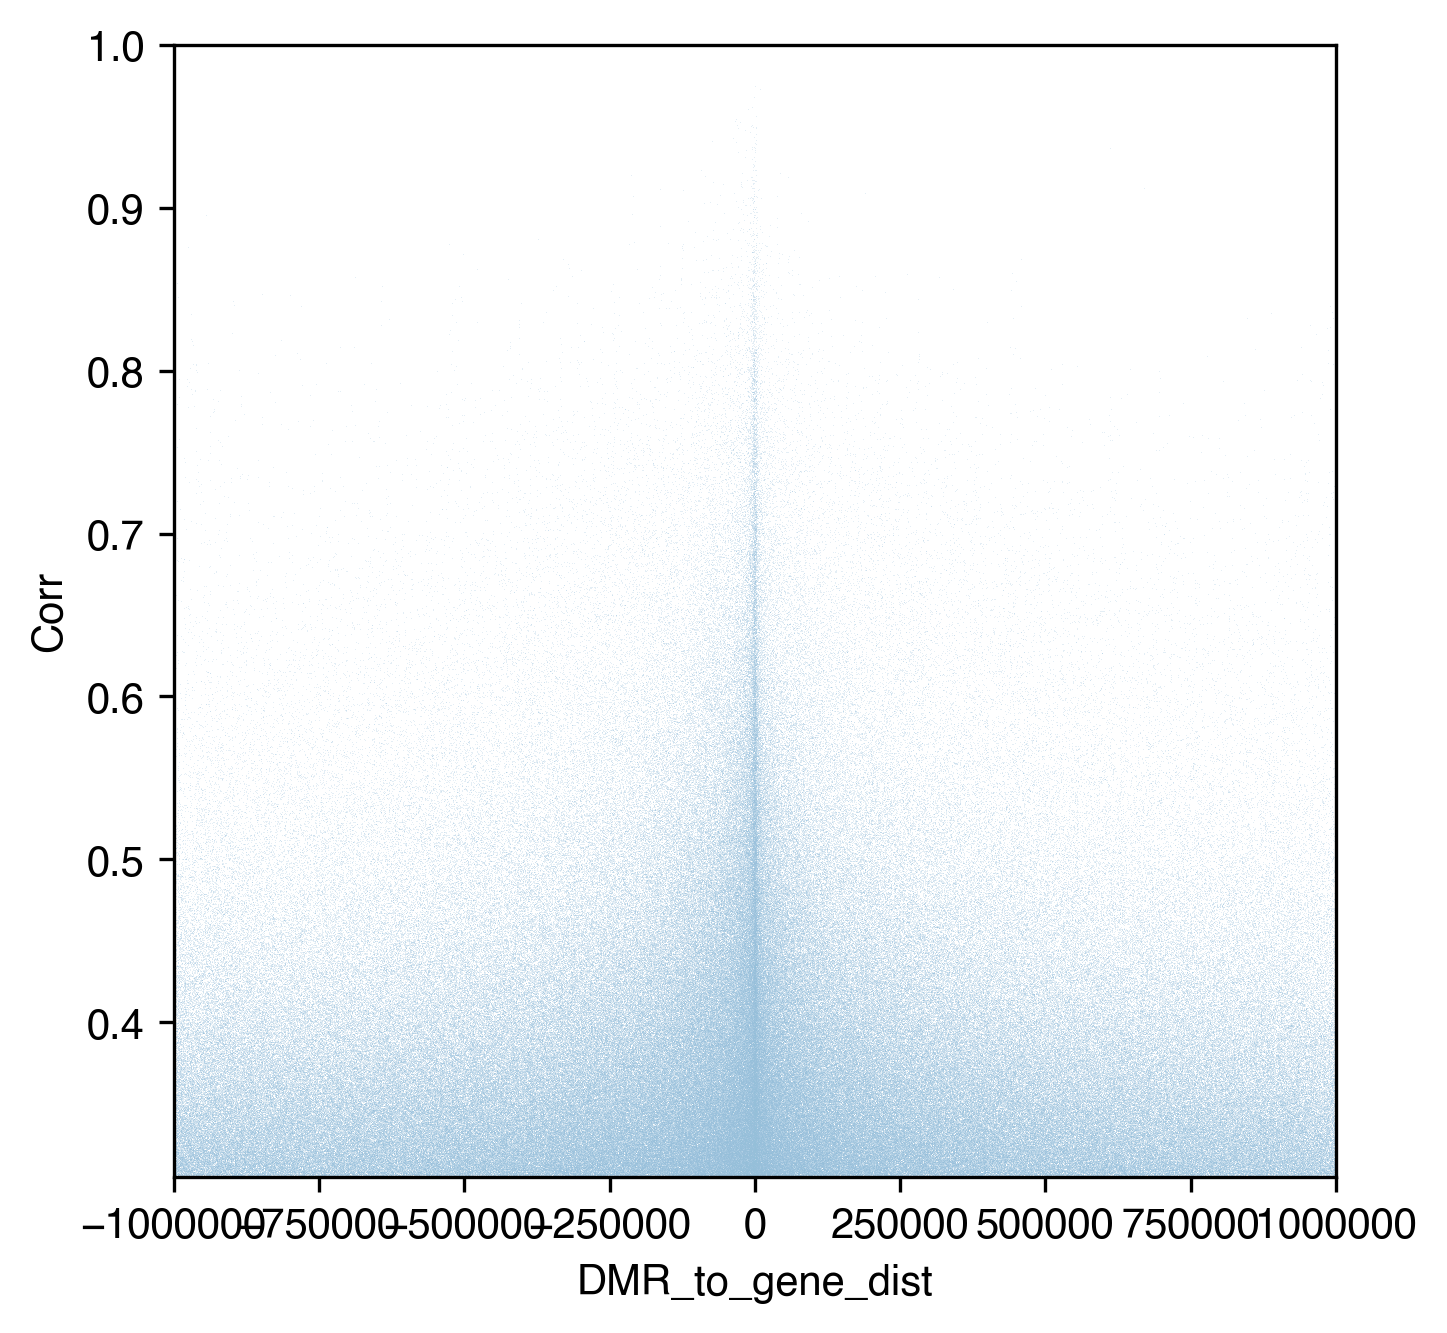

In [93]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.scatterplot(data=sample_loops, 
                x='DMR_to_gene_dist', 
                y='Corr',
                s=0.01, linewidth=0)
# ax.set_xscale('symlog')
ax.set_xlim(-1000000, 1000000)
ax.set_ylim(0.305, 1)

In [94]:
sample_loops[sample_loops['Corr'] > 0.4]['DMR_to_gene_dist'].abs().describe()

count    3.444730e+05
mean     3.189354e+05
std      2.998508e+05
min      0.000000e+00
25%      6.777950e+04
50%      2.206325e+05
75%      5.140540e+05
max      5.316266e+06
Name: DMR_to_gene_dist, dtype: float64

In [102]:
(sample_loops['DMR_to_gene_dist'].abs() < 10000).sum() / 10000

4.2604

## Add DMR Annot

In [6]:
import anndata

dmr_annot = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubDMRAnnotation/DMRAnnotation.h5ad'
)
sig_dmrs = pd.Index(sorted(total_loops['DMR'].unique()))
use_annot = dmr_annot[sig_dmrs, :]

use_annot.write_h5ad(f'TotalGeneDMRCorrLoop.{corr_cutoff}.DMRAnnot.h5ad')
use_annot

AnnData object with n_obs × n_vars = 1951196 × 858 
    var: 'FeatureType'